# Script to read and process netCDF data

## Import libraries

In [1]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import mapping
import geopandas as gpd
import xarray as xr
import rioxarray
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Import shapefile and netCDF data

In [2]:
# Enable Dask's automatic parallelization
dask.config.set(scheduler='threads')

<Axes: >

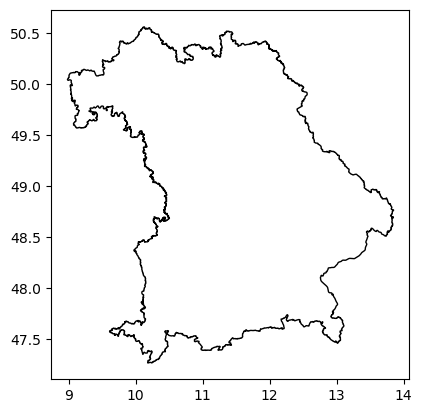

In [3]:
# Load the shapefile
shapefile_path = r"C:\Users\project\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

# check the shapefile
bavaria_polygon.plot(color='white', edgecolor='black')

In [4]:
# Open the netCDF file

data = xr.open_dataset('hydroclim_average+sum.nc').chunk({'variable': 10, 'lat': 1000, 'lon': 1000})

In [5]:
data

<xarray.Dataset> Size: 83GB
Dimensions:    (variable: 19, lat: 13920, lon: 39000)
Coordinates:
  * lat        (lat) float64 111kB -56.0 -55.99 -55.98 ... 59.98 59.99 60.0
  * lon        (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Data variables:
    crs        (variable) |S1 19B dask.array<chunksize=(10,), meta=np.ndarray>
    hydro_avg  (variable, lat, lon) float64 83GB dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               Degree Celsius [°C] * 10; Millimeter [mm]
    Source:              WorldClim, Hijmans et al. (2005)
    Dataset:             Upstream averaged hydroclimatic variables (bioclim)
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

In [6]:
data['hydro_avg']

<xarray.DataArray 'hydro_avg' (variable: 19, lat: 13920, lon: 39000)> Size: 83GB
dask.array<xarray-hydro_avg, shape=(19, 13920, 39000), dtype=float64, chunksize=(10, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 111kB -56.0 -55.99 -55.98 -55.97 ... 59.98 59.99 60.0
  * lon      (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   -1.480000e+02 -5.560000e+01 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   -5.560000e+01 3.680000e+01 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   3.680000e+01 1.292000e+02 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   1.292000e+02 2.216000e+02 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   2.216000e+02 3.140000e+02 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                hydroclim_average+sum
    units:                    Degree Celsius [°C] * 10; Millimeter [mm]

## Clip the netCDF data

In [7]:
# Convert the dataset to use rioxarray for geospatial operations, setting the CRS
data_rio = data.rio.write_crs("EPSG:4326")

In [8]:
# Crop the data using the region of interest, applying the shapefile's geometry
clipped_data = data_rio.rio.clip(bavaria_polygon.geometry.apply(mapping), bavaria_polygon.crs, drop=True)

In [9]:
clipped_data

<xarray.Dataset> Size: 35MB
Dimensions:    (lat: 396, lon: 584, variable: 19)
Coordinates:
  * lat        (lat) float64 3kB 47.27 47.28 47.29 47.3 ... 50.55 50.55 50.56
  * lon        (lon) float64 5kB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
    crs        int32 4B 0
Dimensions without coordinates: variable
Data variables:
    hydro_avg  (variable, lat, lon) float64 35MB dask.array<chunksize=(10, 396, 523), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               Degree Celsius [°C] * 10; Millimeter [mm]
    Source:              WorldClim, Hijmans et al. (2005)
    Dataset:             Upstream averaged hydroclimatic variables (bioclim)
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

## Convert xarray to dataframes

In [10]:
# Flatten the data to check the dimensions required for the dataframe

flat_data = clipped_data['hydro_avg'].stack(space=['lat', 'lon'])
flat_data

<xarray.DataArray 'hydro_avg' (variable: 19, space: 231264)> Size: 35MB
dask.array<reshape, shape=(19, 231264), dtype=float64, chunksize=(10, 115632), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B 0
  * space    (space) object 2MB MultiIndex
  * lat      (space) float64 2MB 47.27 47.27 47.27 47.27 ... 50.56 50.56 50.56
  * lon      (space) float64 2MB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   -1.480000e+02 -5.560000e+01 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   -5.560000e+01 3.680000e+01 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   3.680000e+01 1.292000e+02 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   1.292000e+02 2.216000e+02 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   2.216000e+02 3.140000e+02 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                hydroclim_average+sum
    units:                    Degree Celsius [°C] * 10; Millimeter [mm]

In [11]:
# Prepare the dataframes

hydro_avg = clipped_data['hydro_avg']

# Convert the DataArray to a pandas DataFrame
df = hydro_avg.to_dataframe(name='value').reset_index()
display(df)


# Pivot the DataFrame to have bands as columns
df_pivoted = df.pivot(index=['lat', 'lon'], columns='variable', values='value').reset_index()
display(df_pivoted)

#remove nan values
df_filtered = df_pivoted.dropna(axis=0, how='any').reset_index()

display(df_filtered)


,variable,lat,lon,crs,value
0,0,47.270833,8.979167,0,NaN
1,0,47.270833,8.987500,0,NaN
2,0,47.270833,8.995833,0,NaN
3,0,47.270833,9.004167,0,NaN
4,0,47.270833,9.012500,0,NaN
...,...,...,...,...,...
4394011,18,50.562500,13.804167,0,NaN
4394012,18,50.562500,13.812500,0,NaN
4394013,18,50.562500,13.820833,0,NaN
4394014,18,50.562500,13.829167,0,NaN


variable,lat,lon,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,47.270833,8.979167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.270833,8.987500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47.270833,8.995833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.270833,9.004167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47.270833,9.012500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231259,50.562500,13.804167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231260,50.562500,13.812500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231261,50.562500,13.820833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231262,50.562500,13.829167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


variable,index,lat,lon,0,1,2,3,4,5,6,...,9,10,11,12,13,14,15,16,17,18
0,1902,47.295833,10.229167,51.0,89.0,33.0,6325.0,189.0,-79.0,268.0,...,130.0,-31.0,33503.0,4184.0,1950.0,27.0,11917.0,6160.0,11917.0,6160.0
1,2487,47.304167,10.237500,47.0,87.0,32.0,6276.0,184.0,-81.0,265.0,...,126.0,-34.0,36881.0,4614.0,2140.0,27.0,13139.0,6759.0,13139.0,6759.0
2,2488,47.304167,10.245833,48.0,87.0,33.0,6255.0,184.0,-80.0,264.0,...,126.0,-33.0,42307.0,5308.0,2439.0,28.0,15118.0,7700.0,15118.0,7700.0
3,3073,47.312500,10.254167,47.0,87.0,33.0,6261.0,183.0,-80.0,263.0,...,125.0,-34.0,45645.0,5734.0,2625.0,28.0,16331.0,8287.0,16331.0,8287.0
4,3074,47.312500,10.262500,48.0,87.0,33.0,6253.0,184.0,-80.0,264.0,...,126.0,-33.0,59137.0,7399.0,3428.0,27.0,21069.0,10831.0,21069.0,10831.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,228480,50.529167,10.112500,71.0,91.0,34.0,6353.0,217.0,-48.0,265.0,...,153.0,-10.0,27592.0,2853.0,1659.0,13.0,7791.0,5807.0,7791.0,5807.0
16446,228481,50.529167,10.120833,71.0,91.0,34.0,6353.0,217.0,-47.0,264.0,...,153.0,-9.0,29871.0,3104.0,1801.0,13.0,8460.0,6279.0,8460.0,6279.0
16447,228482,50.529167,10.129167,71.0,91.0,34.0,6342.0,217.0,-47.0,264.0,...,153.0,-9.0,32851.0,3434.0,1987.0,13.0,9340.0,6894.0,9340.0,6894.0
16448,228484,50.529167,10.145833,72.0,91.0,34.0,6348.0,218.0,-46.0,264.0,...,154.0,-8.0,59276.0,6259.0,3620.0,13.0,16951.0,12416.0,16951.0,12416.0


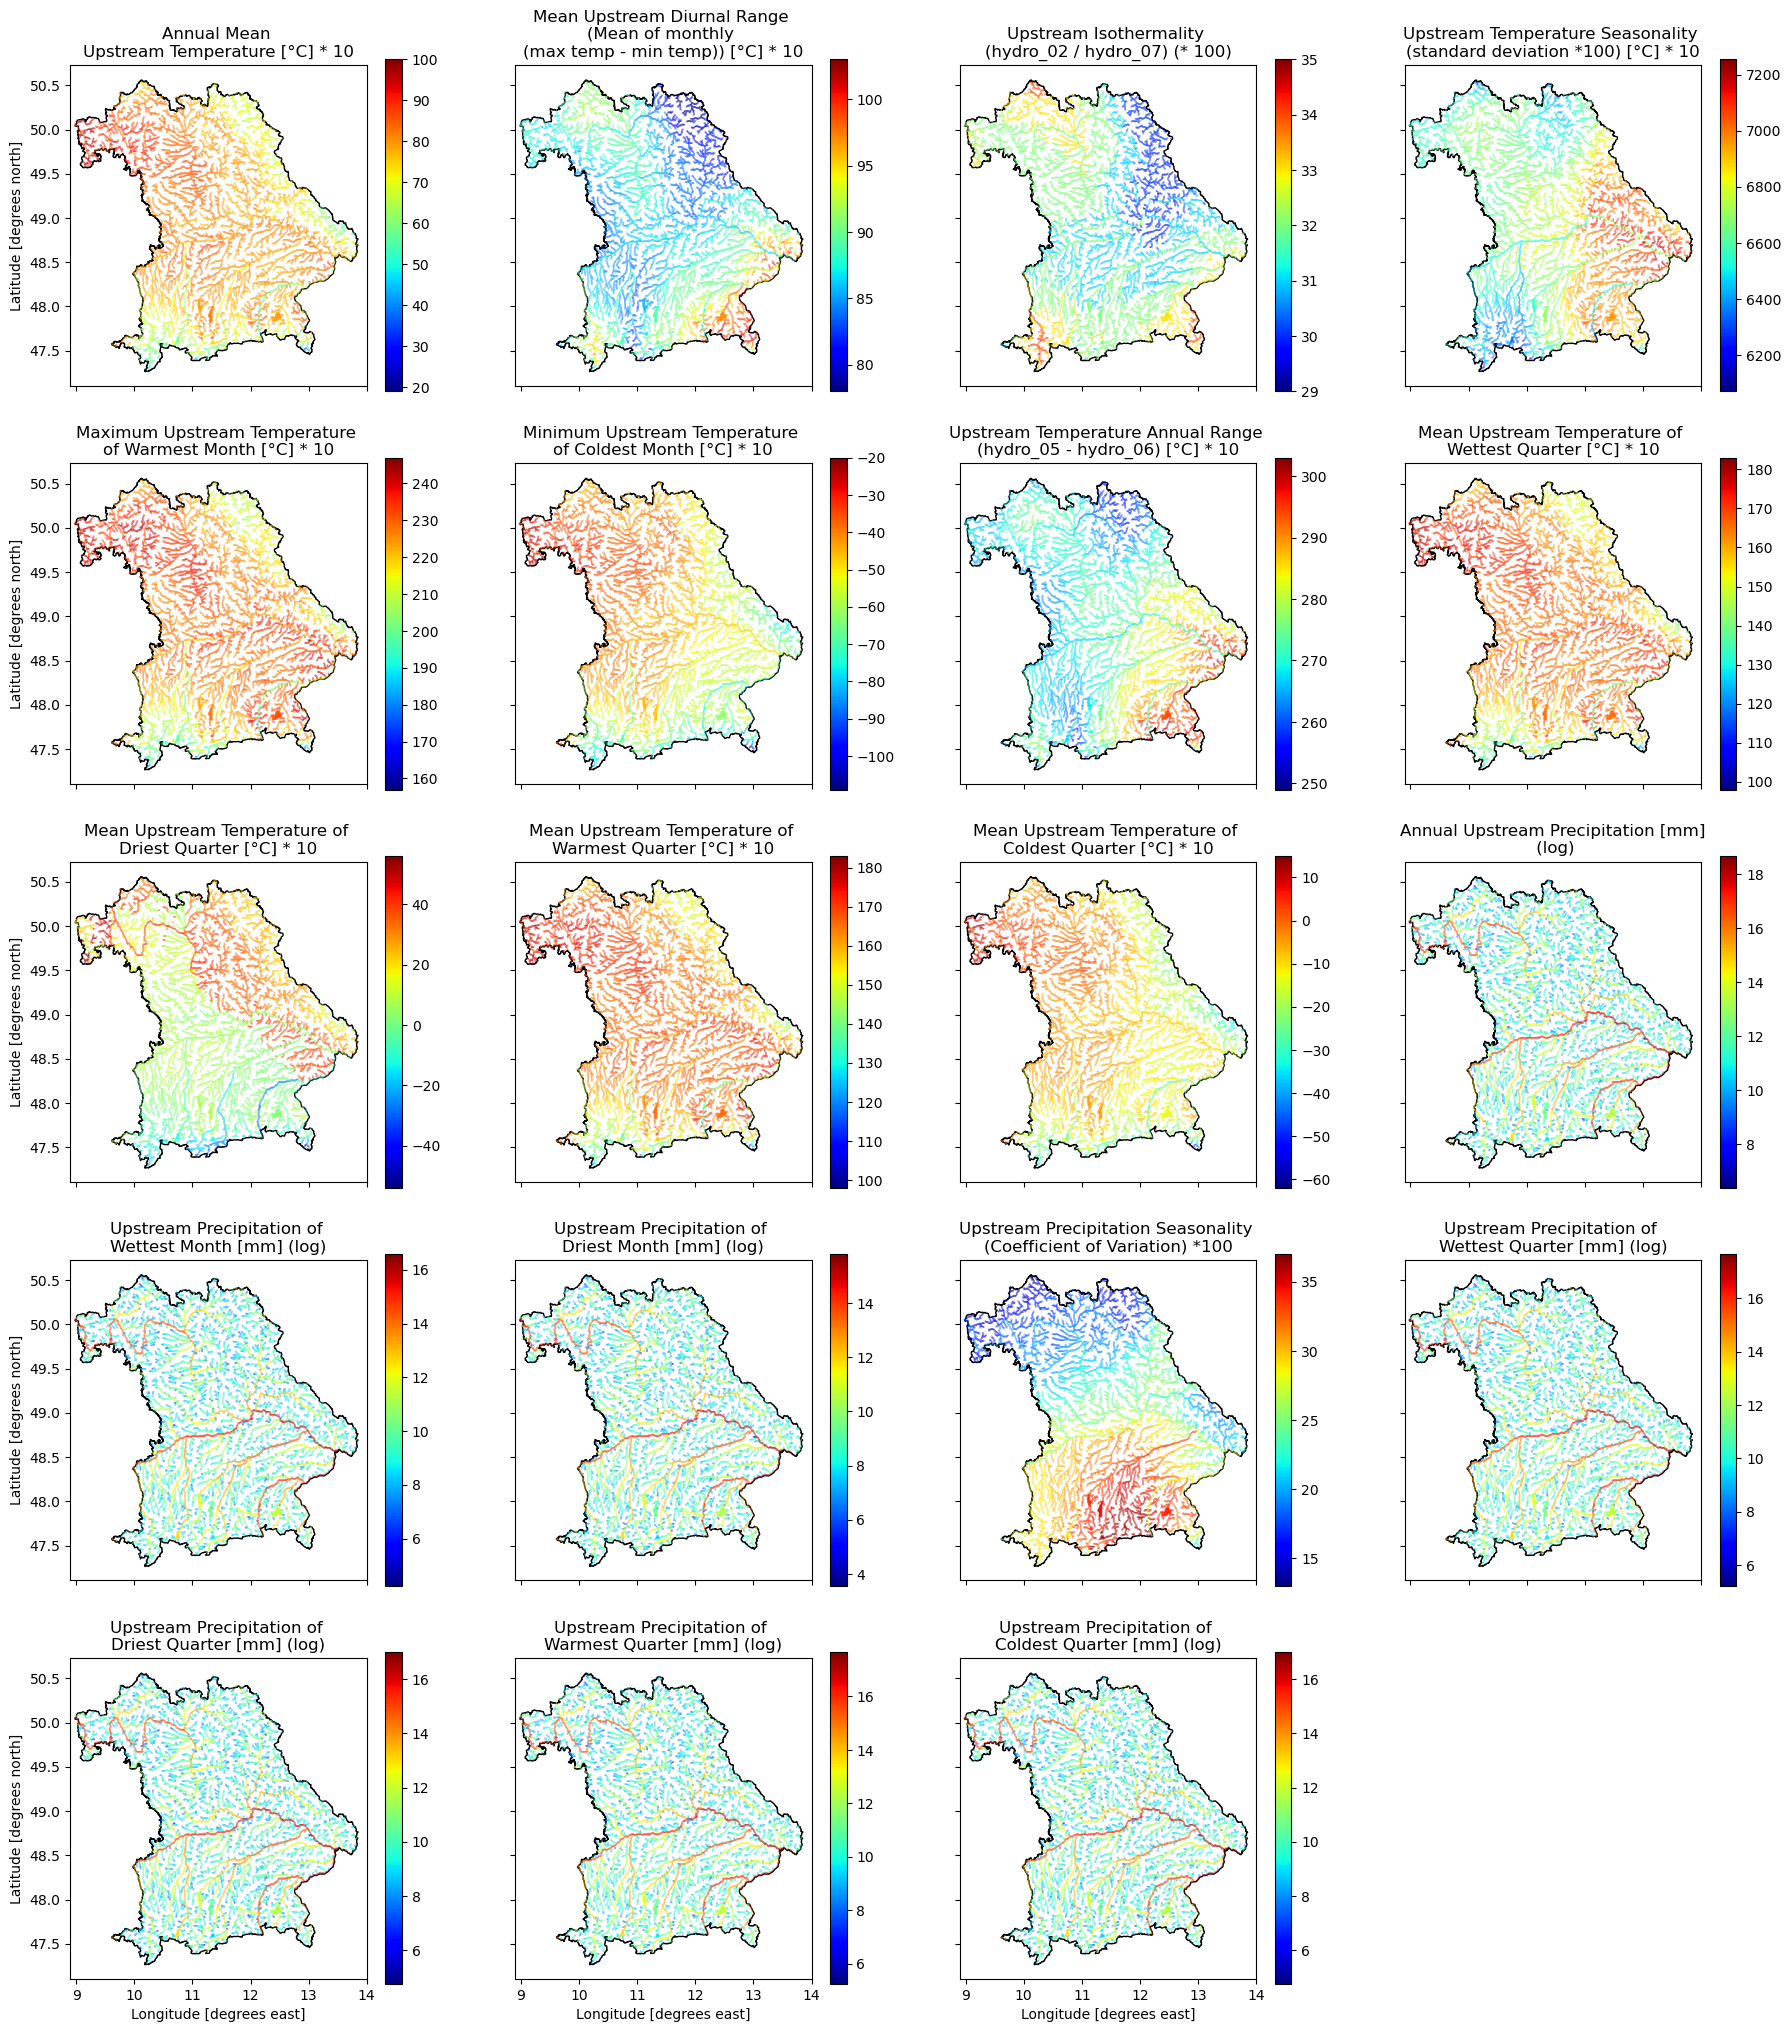

In [17]:
# Plot the clipped hydroclim data (with logarithm for precipitation data)

bands_dict = {
    0:'Annual Mean \nUpstream Temperature [°C] * 10', 
    1:'Mean Upstream Diurnal Range \n(Mean of monthly \n(max temp - min temp)) [°C] * 10', 
    2:'Upstream Isothermality \n(hydro_02 / hydro_07) (* 100)', 
    3:'Upstream Temperature Seasonality \n(standard deviation *100) [°C] * 10', 
    4:'Maximum Upstream Temperature \nof Warmest Month [°C] * 10', 
    5:'Minimum Upstream Temperature \nof Coldest Month [°C] * 10', 
    6:'Upstream Temperature Annual Range \n(hydro_05 - hydro_06) [°C] * 10', 
    7:'Mean Upstream Temperature of \nWettest Quarter [°C] * 10', 
    8:'Mean Upstream Temperature of \nDriest Quarter [°C] * 10', 
    9:'Mean Upstream Temperature of \nWarmest Quarter [°C] * 10',
    10: "Mean Upstream Temperature of \nColdest Quarter [°C] * 10", 
    11:"Annual Upstream Precipitation [mm]\n (log)", 
    12:"Upstream Precipitation of \nWettest Month [mm] (log)", 
    13:"Upstream Precipitation of \nDriest Month [mm] (log)", 
    14:"Upstream Precipitation Seasonality \n(Coefficient of Variation) *100", 
    15:"Upstream Precipitation of \nWettest Quarter [mm] (log)", 
    16:"Upstream Precipitation of \nDriest Quarter [mm] (log)", 
    17:"Upstream Precipitation of \nWarmest Quarter [mm] (log)", 
    18:"Upstream Precipitation of \nColdest Quarter [mm] (log)"}

# Create a 5*4 subplot grid
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(22, 25), sharex=True, sharey=True)

# Flatten the 2D array of subplots for easier iteration
axes = axes.flatten()

for i in range(19):
    bavaria_polygon.plot(ax = axes[i], color='white', edgecolor='black')
    if i in range(11,19) and i != 14:
        scatter = axes[i].scatter(df_filtered['lon'], df_filtered['lat'], c=np.log(df_filtered.iloc[:,i+3]), cmap= 'jet', s= 0.02 )
    else:
        scatter = axes[i].scatter(df_filtered['lon'], df_filtered['lat'], c=df_filtered.iloc[:,i+3], cmap= 'jet', s= 0.02 )
    axes[i].set_title(bands_dict[i])
    axes[i].set_xlim(8.9,14) 
    fig.colorbar(scatter, ax = axes[i])
    if i == 18 or i==17 or i==16:
        axes[i].set_xlabel('Longitude [degrees east]')
    if i in range(0,19,4):
        axes[i].set_ylabel('Latitude [degrees north]')

fig.delaxes(axes[19])

plt.savefig('stations_hydroclim_average_300dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=300)

In [15]:
# save the filtered dataframe
filepath = "df_filtered_hydroclim"
with open(filepath, 'wb') as file:
    pickle.dump(df_filtered, file)